# Install and import dependences

In [1]:
#!pip install --upgrade python-binance tensorflow

In [2]:
from binance.client import Client
from binance import BinanceSocketManager
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, confusion_matrix

# Load data

In [3]:
api_key = "imuSkmeAI4PpxNERZRcnzx6nEkReEhuLedZphxZNphhnUPLR4QH61aXfjnBqUtfH"
api_secret = "56AvdFdOWWoRF20rh6Knq8awDYM145luMDH0XvDMkSD6nffbRwYTCrsxwJmyVLK1"
client = Client(api_key, api_secret)

In [4]:
#Get the exchange info, which contains information about all trading pairs
exchange_info = client.get_exchange_info()

#Extract the symbols of all trading pairs
symbols = [symbol['symbol'] for symbol in exchange_info['symbols'] if "BRL" in symbol['symbol']]

#Filter out only the base cryptocurrencies (e.g., BTC, ETH)
symbols = list(symbol.split(' ')[0] for symbol in symbols)

In [5]:
# Function to fetch historical cryptocurrency data
def fetch_binance_cryptocurrency_data(symbol, start_date, end_date, interval='12h'):
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)

    # Convert data to a Pandas DataFrame
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

database = {}
present_day = dt.date.today()
start_date = '1900-01-01'
end_date = f"{present_day}"
for ticker in symbols:
    data = fetch_binance_cryptocurrency_data(ticker, start_date, end_date)
    database[ticker] = data.close.values.astype(float)

# Model Functions

In [6]:
def model_1(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [7]:
def model_2(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [8]:
def model_3(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [9]:
def model_4(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [10]:
def model_5(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=True),
        SimpleRNN(11, activation='relu', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

# Other Functions

In [11]:
# Suppress the warning related to TensorFlow tracing
tf.autograph.set_verbosity(0)

def pred_eval(model_function, lb_list: list = [11], epochs: int = 100, ticker_list: list = symbols, print_info: bool = True):
    buy_list = []
    total_loss = 0
    total_sold = 0
    for lb in lb_list:
        pred_status_list, true_status_list = [], []
        last_price_list = []
        pred_1_list, pred_2_list = [], []
        count = 0
        total_last_stock_price, total_gamble_stock_price = 0, 0
        total_pred_stock_price, total_true_stock_price = 0, 0
        total_proft = 0

        for ticker in ticker_list:
            count += 1
            price = database[ticker]
            act_status, last_price, pred1, pred2, true_price1, true_price2, loss = model_function(price, look_back = lb, epochs=epochs, ticker=ticker, plot_graph = False)
            
            pred_status_list.append(act_status)
            last_price_list.append(last_price)
            pred_1_list.append(pred1)
            pred_2_list.append(pred2)
            total_loss += loss

            my_act_status = act_status
            my_gamble = sell_price(last_price, pred1, pred2)
            gamble_proft = my_gamble/last_price
            sold_status = check_sold(my_gamble, true_price1)

            if my_gamble/last_price < 1.001 and my_act_status == True: 
                my_act_status = False
            if my_act_status == False: 
                sold_status = None
                gamble_proft = None
            if sold_status:
                total_sold += 1
            

            if print_info:
                print('{:<2} '.format(count), 
                      '{:<8} -'.format(ticker), 
                      'LastPrice: {:<10}'.format(round(float(last_price), 3)), 
                      '/ Pred1: {:<10}'.format(round(float(pred1), 3)), 
                      '/ Pred2: {:<10}'.format(round(float(pred2), 3)), 
                      '/ TruePrice1: {:<10}'.format(round(float(true_price1), 3)), 
                      '/ TruePrice2: {:<10}'.format(round(float(true_price2), 3)), 
                      '|| ActStatus: {:<1}'.format(act_status), 
                      '/ MyActStatus: {:<1}'.format(my_act_status), 
                      '/ SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''), 
                      '/ MyGamble: {:<10}'.format(round(float(my_gamble), 3)), 
                      '/ GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                      '/ TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                      '|| CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0)))
                            

            true_proft = true_price1 - last_price
            if act_status:
                total_last_stock_price += last_price
                total_pred_stock_price += pred1
                total_gamble_stock_price += my_gamble
                total_true_stock_price += true_price1
            if true_proft > 0:
                true_status_list.append(True)
            if true_proft <= 0:
                true_status_list.append(False)
                
            if act_status and my_act_status:
                buy = ['{:<8}'.format(ticker), 
                       'LastPrice: {:<11}'.format(round(float(last_price), 5)), 
                       'MyGamble: {:<11}'.format(round(float(my_gamble), 5)), 
                       'TruePrice: {:<11}'.format(round(float(true_price1), 5)),
                       'GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                       'TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                       'SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''),
                       'CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0))]
                buy_list.append(buy)
                      

        if not total_last_stock_price == 0:
            print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
            print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
            print('True proft %:', total_true_stock_price / total_last_stock_price)
        if total_last_stock_price == 0:
            print('\nAll False')

        if len(buy_list) != 0:
            print('\nLook Back:', lb, '/ Total Loss:', total_loss, '/ Sold Portion:', total_sold/len(buy_list), '\n')
        if len(buy_list) == 0:
            print('\nLook Back:', lb, '/ Total Loss:', total_loss, '/ Sold Portion:', '\n') 
        
        for i in buy_list:
            print(i)
    
        index = my_confusion_matrix(true_status_list, pred_status_list)
        if len(index) > 0: 
            print('Wrong Buy_Act List:')
            for i in index:
                print(symbols[i], '\n')

In [12]:
def my_confusion_matrix(true_status: list, pred_status: list):
    cm = confusion_matrix(true_status, pred_status)
    labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    cm = cm.reshape((2, 2))
    
    # Print indices where true and pred statuses are False and True respectively
    false_true_indices = []
    for i in range(len(true_status)):
        if true_status[i] == False and pred_status[i] == True:
            false_true_indices.append(i)
    
    # Calculate accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    print("CM accuracy:", accuracy)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return false_true_indices 

In [13]:
def sell_price(last_value, pred1, pred2, margin = 0.001):
    'Optmize the sell price'
    if pred1 <= last_value and abs(last_value - pred1) <= (pred1*0.0025):
        return last_value
    
    if (pred1 - (pred1*margin)) <= last_value:
        return last_value
    
    if pred2/pred1 >= 1.05:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 + (pred1 * margin) <= last_value * 1.02:
            return pred1 + (pred1 * margin)
        else:
            return last_value * 1.02
    
    if pred2/pred1 >= 1.01:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 <= last_value * 1.02:
            return pred1
        else: 
            return last_value * 1.02

    else:
        return pred1 - (pred1 * margin)

In [14]:
def check_sold(gamble, true_price, margin = 0.002):
    'Check if the gamble price was sold'
    return gamble <= true_price + (true_price * margin)

# Predictions & Evaluate


Pred proft %: 1.0082397018076141
Gamble proft %: 1.0072905657923694
True proft %: 1.000656354092141

Look Back: 1 / Total Loss: 67008526.40416624 / Sold Portion: 0.75 

['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2689.74994 ', 'TruePrice: 2667.0     ', 'GambleProft: 1.007', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01472    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.016', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.14796    ', 'TruePrice: 6.194      ', 'GambleProft: 1.008', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.20218   ', 'TruePrice: 69.73      ', 'GambleProft: 1.006', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.32476   ', 'TruePrice: 38.75      ', 'GambleProft: 1.006', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectM

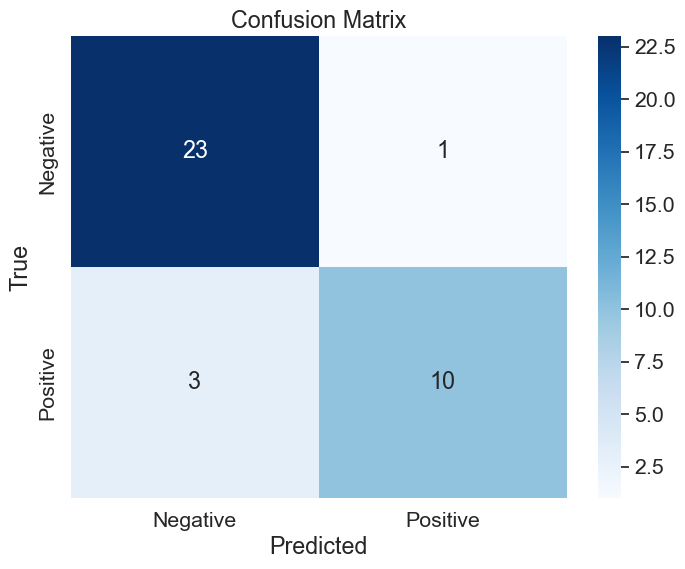

Wrong Buy_Act List:
BNBBRL 

0:07:27.312855

Pred proft %: 1.0086968997230403
Gamble proft %: 1.0089717508769378
True proft %: 1.051140370673362

Look Back: 1 / Total Loss: 76411875.85446659 / Sold Portion: 0.75 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.9949     ', 'TruePrice: 4.977      ', 'GambleProft: 1.005', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.29545  ', 'TruePrice: 109.59     ', 'GambleProft: 1.015', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.31971   ', 'TruePrice: 69.73      ', 'GambleProft: 1.008', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.2694    ', 'TruePrice: 38.75      ', 'GambleProft: 1.004', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.60336   ', 'TruePrice: 19.78      ', 'GambleProft: 1.005', '

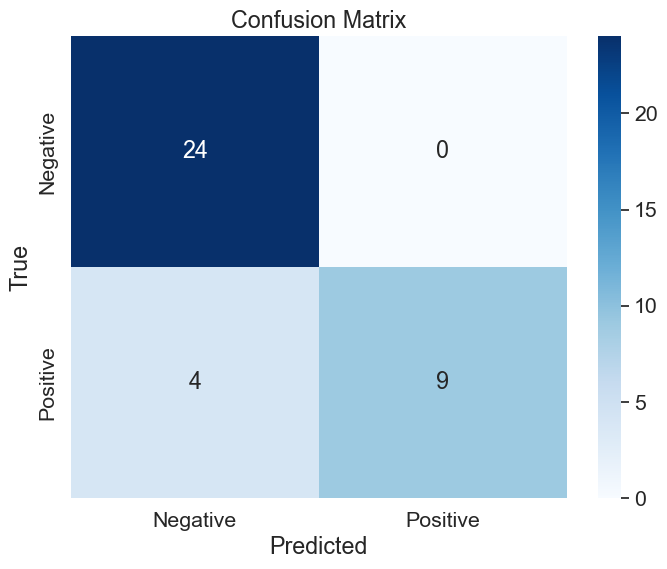

0:06:44.894463

Pred proft %: 1.0083448577304355
Gamble proft %: 1.0073693242279895
True proft %: 1.000681754565156

Look Back: 1 / Total Loss: 75295164.84110525 / Sold Portion: 0.7692307692307693 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.03039    ', 'TruePrice: 5.041      ', 'GambleProft: 1.001', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2689.2063  ', 'TruePrice: 2667.0     ', 'GambleProft: 1.007', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98283    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.14848    ', 'TruePrice: 6.194      ', 'GambleProft: 1.008', 'TrueProft: 1.015

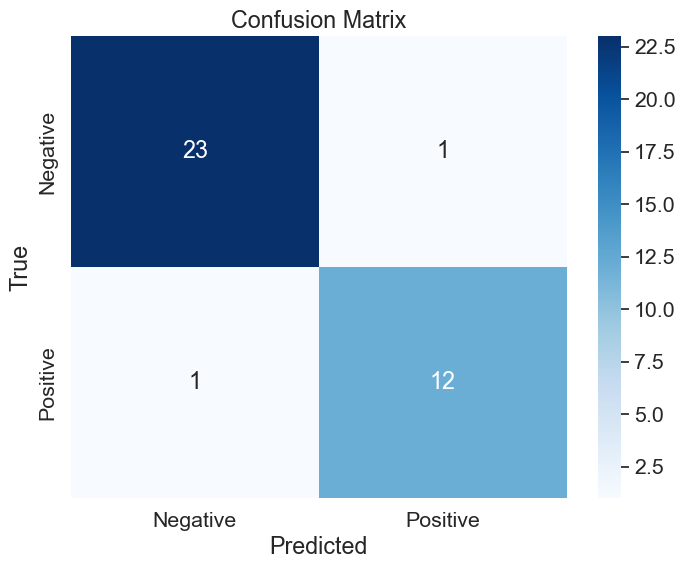

Wrong Buy_Act List:
BNBBRL 

0:07:09.317843

Pred proft %: 1.0060700816745825
Gamble proft %: 1.0057971892454052
True proft %: 1.0506010854020726

Look Back: 1 / Total Loss: 112996414.92483455 / Sold Portion: 0.6666666666666666 

['XRPBRL  ', 'LastPrice: 3.107      ', 'MyGamble: 3.25457    ', 'TruePrice: 3.065      ', 'GambleProft: 1.047', 'TrueProft: 0.986', 'SoldStatus: 0', 'CorrectModel: 0']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.29335  ', 'TruePrice: 109.59     ', 'GambleProft: 1.005', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00098    ', 'MyGamble: 0.00145    ', 'TruePrice: 0.00096    ', 'GambleProft: 1.472', 'TrueProft: 0.971', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.92218   ', 'TruePrice: 69.73      ', 'GambleP

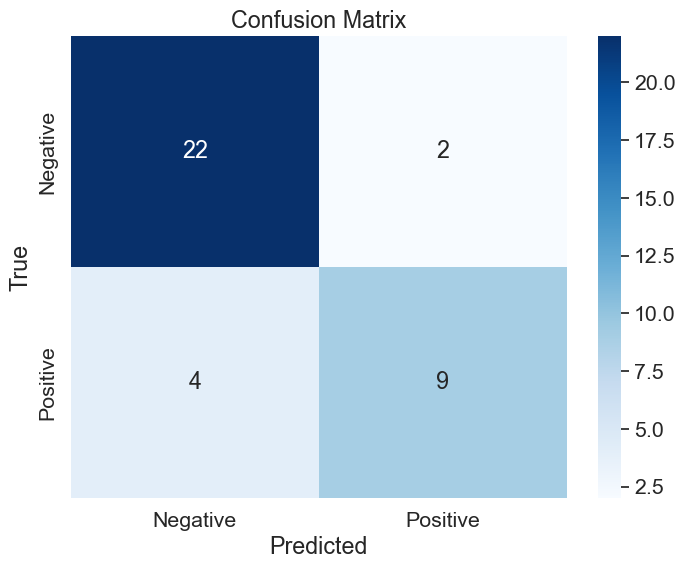

Wrong Buy_Act List:
XRPBRL 

WINBRL 

0:08:03.680557

Pred proft %: 1.0093052452186437
Gamble proft %: 1.0096523081058908
True proft %: 1.053896138320673

Look Back: 1 / Total Loss: 66088986.50202039 / Sold Portion: 1.0 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98619    ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.77755  ', 'TruePrice: 109.59     ', 'GambleProft: 1.019', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.07848   ', 'TruePrice: 69.73      ', 'GambleProft: 1.004', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.21153   ', 'TruePrice: 38.75      ', 'GambleProft: 1.003', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['GMTBRL  ', 'LastPrice: 1.317      ', 'MyGamble: 1.32721    ', 'TruePrice: 1.337      ', 'GambleProft: 1.

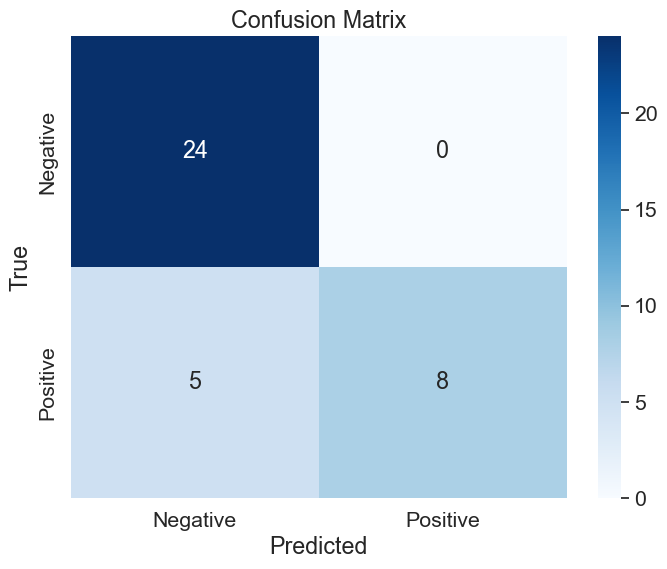

0:07:47.549300

Pred proft %: 1.0023298134637673
Gamble proft %: 1.0031892193535379
True proft %: 1.0549130610594417

Look Back: 1 / Total Loss: 75466590.71080464 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04829    ', 'TruePrice: 5.041      ', 'GambleProft: 1.005', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.95211   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.62181   ', 'TruePrice: 38.75      ', 'GambleProft: 1.014', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.90842    ', 'TruePrice: 1.923      ', 'GambleProft: 1.02 ', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.4525     ', 'TruePrice: 8.72       ', 'GambleProft: 1.01 ', 'TrueProft: 1.042', 'SoldStatus

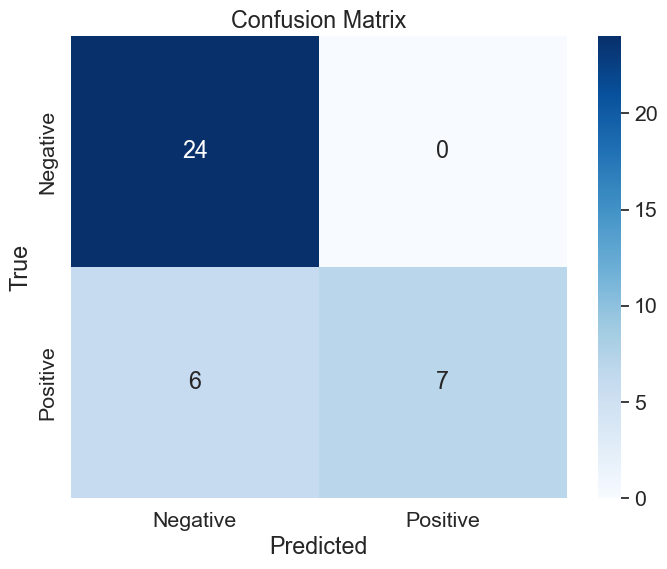

0:08:02.636743

Pred proft %: 1.0075107541643693
Gamble proft %: 1.0077898051835714
True proft %: 1.0531558051469097

Look Back: 1 / Total Loss: 55680031.16728196 / Sold Portion: 1.0 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.36339  ', 'TruePrice: 109.59     ', 'GambleProft: 1.015', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.17411    ', 'TruePrice: 6.194      ', 'GambleProft: 1.012', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.05358   ', 'TruePrice: 69.73      ', 'GambleProft: 1.004', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.29083   ', 'TruePrice: 38.75      ', 'GambleProft: 1.005', 'TrueProft: 1.017', 'SoldStatus

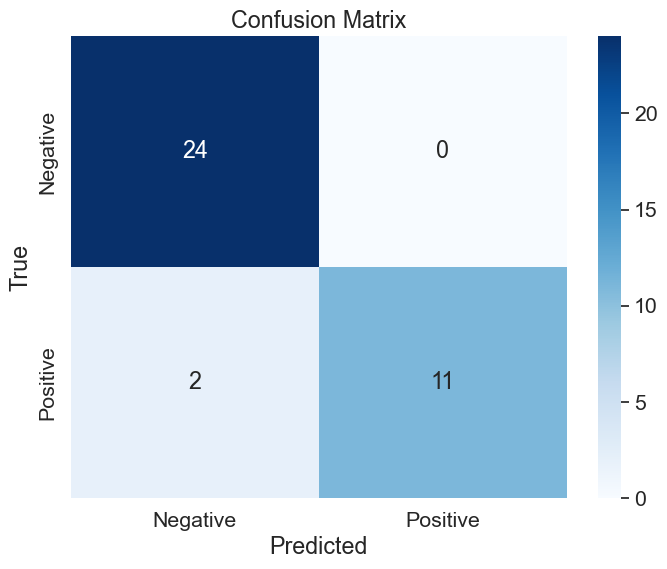

0:08:23.769760

Pred proft %: 1.0090502108204653
Gamble proft %: 1.0089955726255264
True proft %: 1.0251431777765925

Look Back: 1 / Total Loss: 72211043.69695927 / Sold Portion: 0.6666666666666666 

['ADABRL  ', 'LastPrice: 3.656      ', 'MyGamble: 4.27447    ', 'TruePrice: 3.615      ', 'GambleProft: 1.169', 'TrueProft: 0.989', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01473    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.017', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00098    ', 'MyGamble: 0.00114    ', 'TruePrice: 0.00096    ', 'GambleProft: 1.153', 'TrueProft: 0.971', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.09776   ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.35133   ', 'TruePrice: 38.75      ', 'GambleProft: 1.007', 'TrueProft: 1.01

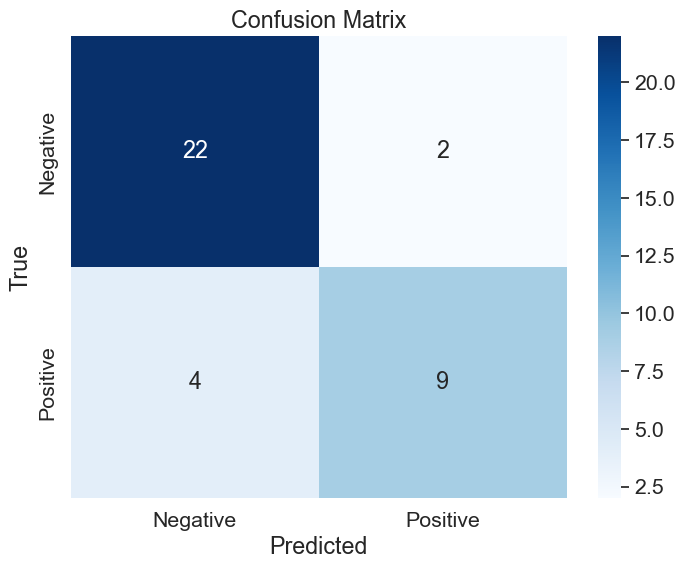

Wrong Buy_Act List:
ADABRL 

WINBRL 

0:08:39.647962

Pred proft %: 1.006680526355077
Gamble proft %: 1.0064857072680427
True proft %: 1.0279298299389747

Look Back: 1 / Total Loss: 77619647.77721012 / Sold Portion: 0.7777777777777778 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97978    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.13796    ', 'TruePrice: 6.194      ', 'GambleProft: 1.006', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.06092   ', 'TruePrice: 69.73      ', 'GambleProft: 1.004', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.88713    ', 'TruePrice: 1.923      ', 'GambleProft: 1.009', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.8257    ', 'TruePrice: 19.78      ', 

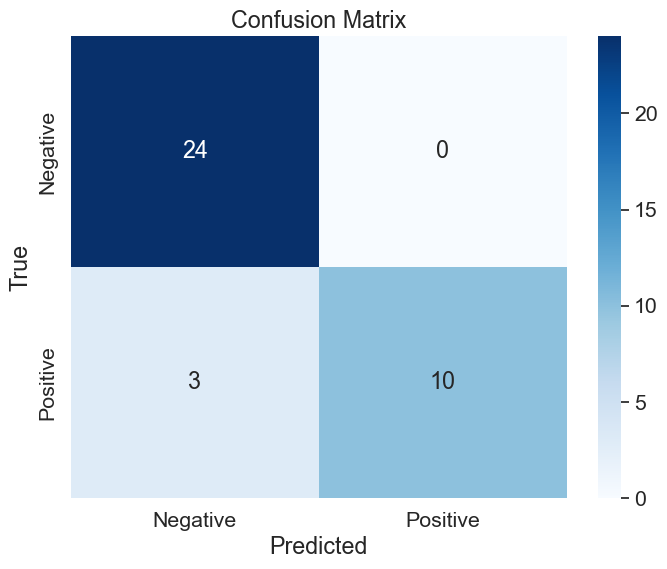

0:09:12.748751

Pred proft %: 1.0037102265679012
Gamble proft %: 1.0041076434157665
True proft %: 1.0512519410958472

Look Back: 1 / Total Loss: 66144030.47444439 / Sold Portion: 1.0 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.14551  ', 'TruePrice: 109.59     ', 'GambleProft: 1.003', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.11767    ', 'TruePrice: 6.194      ', 'GambleProft: 1.003', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.68368   ', 'TruePrice: 38.75      ', 'GambleProft: 1.015', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.90204    ', 'TruePrice: 1.923      ', 'GambleProft: 1.017', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.55416   ', 'TruePrice: 19.78      ', 'GambleProft: 1.002', 'TrueProft: 1.014', 'SoldStatu

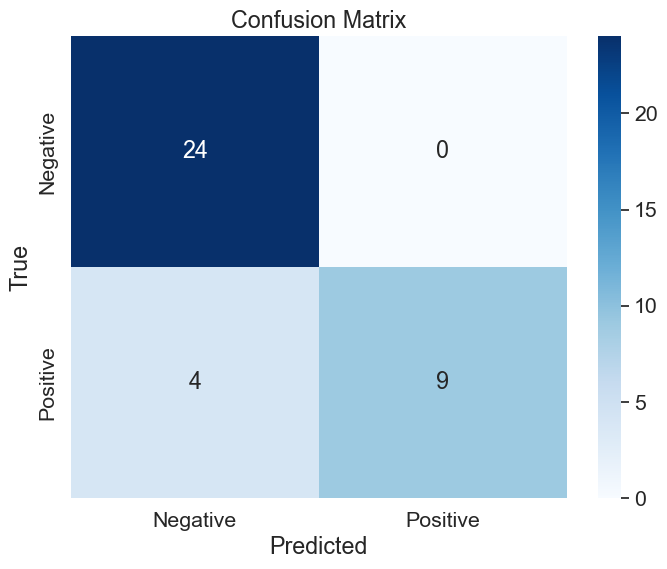

0:09:06.784190


In [15]:
for i in range(10):
    d = dt.datetime.now()
    pred_eval(model_4, epochs = 100, lb_list = [1], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)


Pred proft %: 1.0040116122836542
Gamble proft %: 1.0038366888905539
True proft %: 1.0255917936532355

Look Back: 1 / Total Loss: 57252001.8871437 / Sold Portion: 1.0 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04599    ', 'TruePrice: 5.041      ', 'GambleProft: 1.004', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97684    ', 'TruePrice: 4.977      ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.10089   ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.19428   ', 'TruePrice: 38.75      ', 'GambleProft: 1.002', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.79046   ', 'TruePrice: 19.78      ', 'GambleProft: 1.014', 'TrueProft: 1.014', 'SoldStatus: 1', 'CorrectM

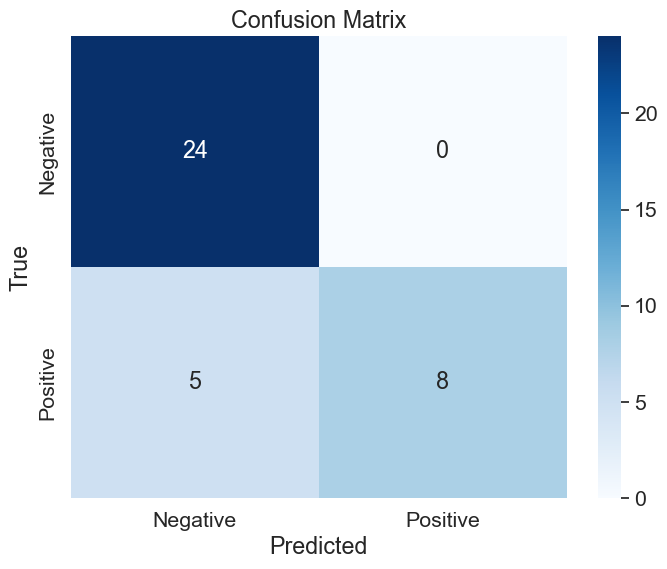

0:10:33.803654

Pred proft %: 1.006571450686935
Gamble proft %: 1.0056968651707652
True proft %: 1.0254620546898336

Look Back: 1 / Total Loss: 72043004.63690335 / Sold Portion: 0.8571428571428571 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.97878    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01458    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.007', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.14884   ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.25866   ', 'TruePrice: 38.75      ', 'GambleProft: 1.004', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.9002    ', 'TruePrice: 19.78      ', 'GambleProft: 1.02 ', 'TrueProft: 1.01

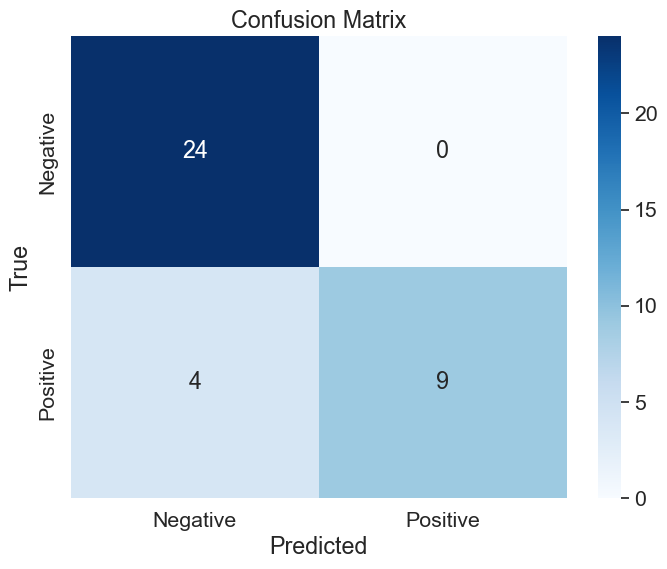

0:08:28.727047

Pred proft %: 1.010339305629135
Gamble proft %: 1.010162731814117
True proft %: 1.0248681429420188

Look Back: 1 / Total Loss: 54653087.98978016 / Sold Portion: 0.625 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.9857     ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00098    ', 'MyGamble: 0.00112    ', 'TruePrice: 0.00096    ', 'GambleProft: 1.134', 'TrueProft: 0.971', 'SoldStatus: 0', 'CorrectModel: 0']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.14468    ', 'TruePrice: 6.194      ', 'GambleProft: 1.007', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.09704   ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.8568    ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus

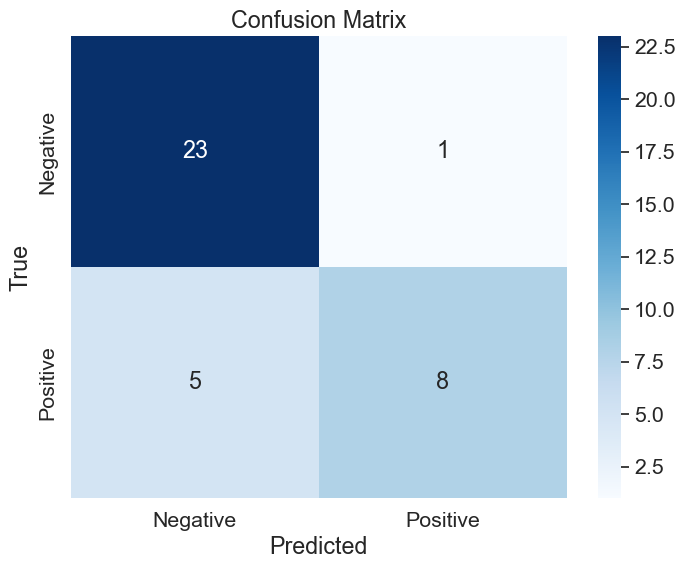

Wrong Buy_Act List:
WINBRL 

0:08:32.405413

Pred proft %: 1.0072856726961115
Gamble proft %: 1.00728398646244
True proft %: 1.028917168129953

Look Back: 1 / Total Loss: 72496767.44752711 / Sold Portion: 0.875 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98357    ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.15905    ', 'TruePrice: 6.194      ', 'GambleProft: 1.009', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.86162   ', 'TruePrice: 69.73      ', 'GambleProft: 1.001', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.69228   ', 'TruePrice: 38.75      ', 'GambleProft: 1.016', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.90109    ', 'TruePrice: 1.923      ', 'GambleProft: 1.016', 'Tr

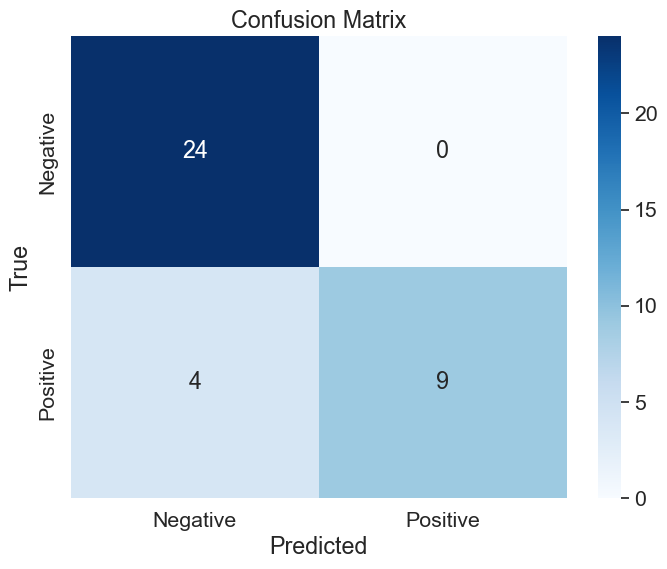

0:08:30.432209

Pred proft %: 1.0029878450207337
Gamble proft %: 1.0020233776182697
True proft %: 1.0036079827970938

Look Back: 1 / Total Loss: 66569882.79183728 / Sold Portion: 0.5 

['BNBBRL  ', 'LastPrice: 2670.0     ', 'MyGamble: 2673.27229 ', 'TruePrice: 2667.0     ', 'GambleProft: 1.001', 'TrueProft: 0.999', 'SoldStatus: 0', 'CorrectModel: 0']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.71996  ', 'TruePrice: 109.59     ', 'GambleProft: 1.019', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00098    ', 'MyGamble: 0.00197    ', 'TruePrice: 0.00096    ', 'GambleProft: 2.002', 'TrueProft: 0.971', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 66.93576   ', 'TruePrice: 69.73      ', 'GambleProft: 1.002', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.9002    ', 'TruePrice: 19.78      ', 'GambleProft: 1.02 ', 'TrueProft: 1.014', 'SoldStatu

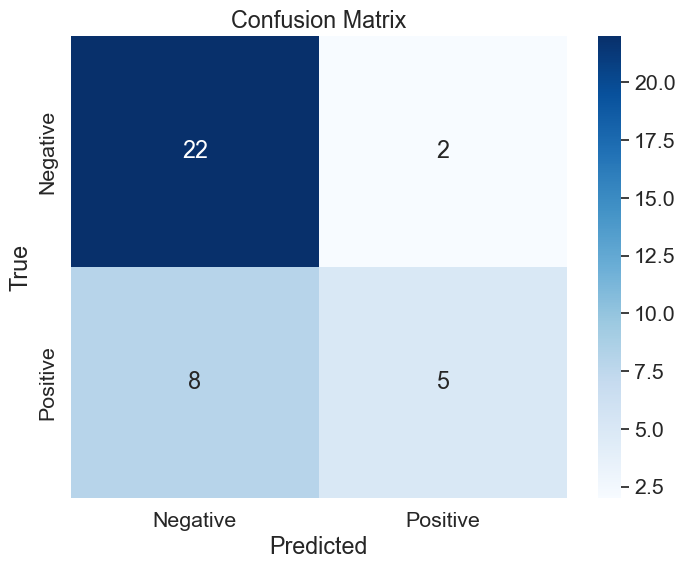

Wrong Buy_Act List:
BNBBRL 

WINBRL 

0:08:30.099489

Pred proft %: 1.0049546798923137
Gamble proft %: 1.0055215012749577
True proft %: 1.053896138320673

Look Back: 1 / Total Loss: 70572097.45499179 / Sold Portion: 0.8 

['USDTBRL ', 'LastPrice: 5.024      ', 'MyGamble: 5.04763    ', 'TruePrice: 5.041      ', 'GambleProft: 1.005', 'TrueProft: 1.003', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.94468  ', 'TruePrice: 109.59     ', 'GambleProft: 1.011', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['GMTBRL  ', 'LastPrice: 1.317      ', 'MyGamble: 1.34334    ', 'TruePrice: 1.337      ', 'GambleProft: 1.02 ', 'TrueProft: 1.015', 'SoldStatus: 0', 'CorrectModel: 1']
['GALBRL  ', 'LastPrice: 8.37       ', 'MyGamble: 8.42376    ', 'TruePrice: 8.72       ', 'GambleProft: 1.006', 'TrueProft: 1.042', 'SoldStatus: 1', 'CorrectModel: 1']
['APTBRL  ', 'LastPrice: 39.67      ', 'MyGamble: 39.91788   ', 'TruePrice: 40.17      ', 'GambleProft: 1.

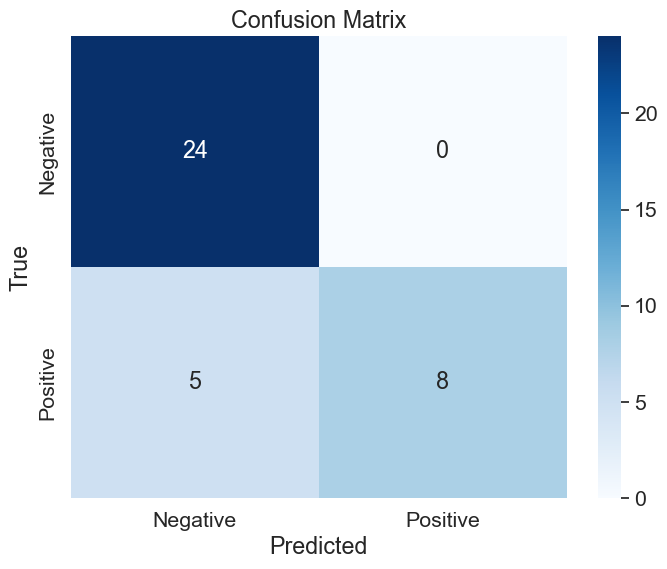

0:08:06.820216

Pred proft %: 1.0117073264241054
Gamble proft %: 1.0113944810233566
True proft %: 1.0542915467400829

Look Back: 1 / Total Loss: 46164220.759511694 / Sold Portion: 0.6666666666666666 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98104    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.36537  ', 'TruePrice: 109.59     ', 'GambleProft: 1.015', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.18582   ', 'TruePrice: 69.73      ', 'GambleProft: 1.006', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.862     ', 'TruePrice: 38.75      ', 'GambleProft: 1.02 ', 'TrueProft: 1.017', 'SoldStatus: 0', 'CorrectModel: 1']
['GMTBRL  ', 'LastPrice: 1.317      ', 'MyGamble: 1.34334    ', 'TruePrice: 1.337      ', 'GambleProft: 1.02 ', 'TrueProft: 1.0

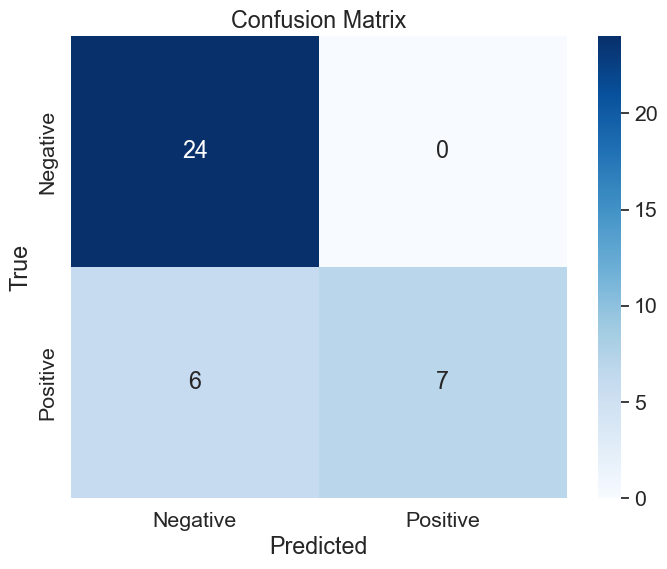

0:08:05.842676

Pred proft %: 1.0071473365064199
Gamble proft %: 1.0070574025459884
True proft %: 1.0284689655823482

Look Back: 1 / Total Loss: 60133564.51785362 / Sold Portion: 1.0 

['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01477    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 6.102      ', 'MyGamble: 6.15135    ', 'TruePrice: 6.194      ', 'GambleProft: 1.008', 'TrueProft: 1.015', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.35617   ', 'TruePrice: 69.73      ', 'GambleProft: 1.008', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.1       ', 'MyGamble: 38.17201   ', 'TruePrice: 38.75      ', 'GambleProft: 1.002', 'TrueProft: 1.017', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.871      ', 'MyGamble: 1.90752    ', 'TruePrice: 1.923      ', 'GambleProft: 1.02 ', 'TrueProft: 1.028', 'SoldStatus

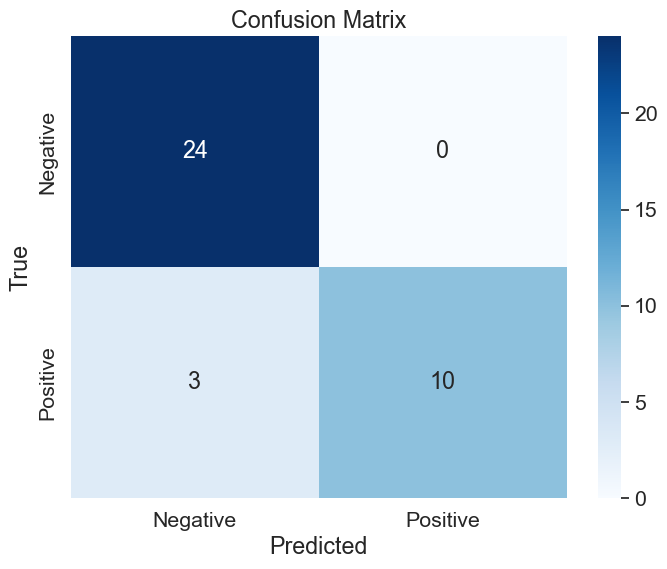

0:08:11.031737

Pred proft %: 1.0027686747359776
Gamble proft %: 1.0016126821496296
True proft %: 1.003721761671906

Look Back: 1 / Total Loss: 68810993.32868485 / Sold Portion: 0.8 

['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 101.8368   ', 'TruePrice: 109.59     ', 'GambleProft: 1.02 ', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01448    ', 'MyGamble: 0.01469    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.014', 'TrueProft: 1.031', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.00098    ', 'MyGamble: 0.0015     ', 'TruePrice: 0.00096    ', 'GambleProft: 1.524', 'TrueProft: 0.971', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.12376   ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.75237   ', 'TruePrice: 19.78      ', 'GambleProft: 1.012', 'TrueProft: 1.014', 'SoldStatus

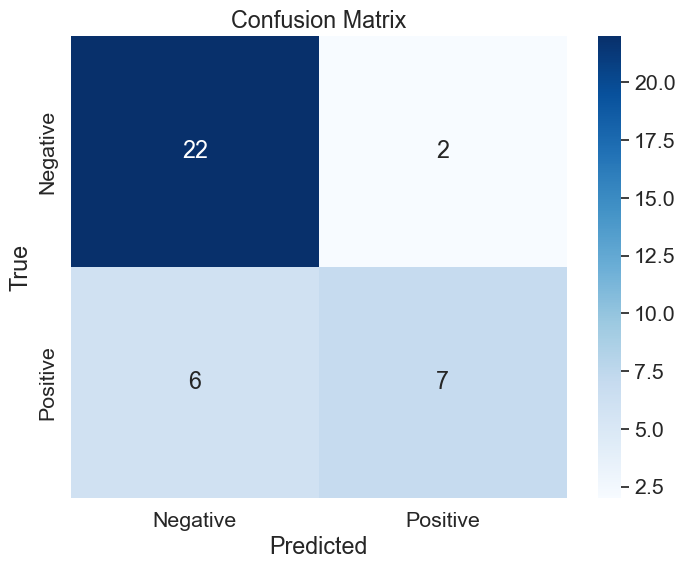

Wrong Buy_Act List:
BNBBRL 

WINBRL 

0:08:05.314038

Pred proft %: 1.0026385447025636
Gamble proft %: 1.003071083897884
True proft %: 1.0512648400491773

Look Back: 1 / Total Loss: 79407445.98013228 / Sold Portion: 0.8333333333333334 

['BUSDBRL ', 'LastPrice: 4.971      ', 'MyGamble: 4.98288    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.84      ', 'MyGamble: 100.21112  ', 'TruePrice: 109.59     ', 'GambleProft: 1.004', 'TrueProft: 1.098', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 66.79      ', 'MyGamble: 67.09867   ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.044', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.51      ', 'MyGamble: 19.6546    ', 'TruePrice: 19.78      ', 'GambleProft: 1.007', 'TrueProft: 1.014', 'SoldStatus: 1', 'CorrectModel: 1']
['GALABRL ', 'LastPrice: 0.3609     ', 'MyGamble: 0.36812    ', 'TruePrice: 0.4147     ', 

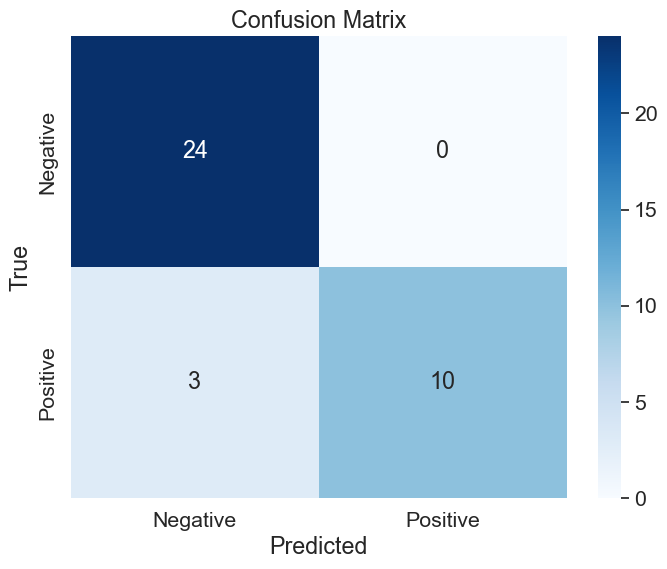

0:08:04.661421


In [16]:
for i in range(10):
    d = dt.datetime.now()
    pred_eval(model_5, epochs = 100, lb_list = [1], ticker_list = symbols, print_info = False)
    d2 = dt.datetime.now()
    print(d2-d)

# Make a dataframe and save results

In [70]:
import threading
import multiprocessing
import os

# Function to execute in threads or processes
def your_function():
    pred_eval(model_1, epochs = 5000, lb_list = [11], ticker_list = symbols[:3])

def run_multithreading():
    num_threads = os.cpu_count()  # Use all available CPU cores
    threads = []
    for _ in range(num_threads):
        thread = threading.Thread(target=your_function)
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()

def run_multiprocessing():
    num_processes = os.cpu_count()  # Use all available CPU cores
    processes = []
    for _ in range(num_processes):
        process = multiprocessing.Process(target=your_function)
        process.start()
        processes.append(process)
    for process in processes:
        process.join()
        
your_function()

KeyboardInterrupt: 

In [ ]:
#csv_file = df.to_csv(f"Prediction_{present_day}.csv",index=False)

In [ ]:
dic = {"Ticker":[],"Act":[],"LastPrice":[],"Pred1":[],"Pred2":[]}
for ticker, status, last_price, pred_1, pred_2 in zip(symbols, pred_status_list, last_price_list, pred_1_list, pred_2_list):
    dic["Ticker"].append(ticker)
    dic["Act"].append(status)
    dic["LastPrice"].append(last_price)
    dic["Pred1"].append(pred_1)
    dic["Pred2"].append(pred_2)
df = pd.DataFrame(dic)
display(df)
display(df.loc[df["Act"]==True])

In [ ]:
pred_status_list, true_status_list = [], []
last_price_list = []
pred_1_list, pred_2_list = [], []
total_last_stock_price, total_pred_stock_price, total_true_stock_price = 0, 0, 0

for ticker in symbols:
    price = database[ticker]
    status, last_price, pred1, pred2, true_price1, true_price2 = predict(price, ticker=ticker)
    pred_status_list.append(status)
    last_price_list.append(last_price)
    pred_1_list.append(pred1)
    pred_2_list.append(pred2)
    pred_proft, true_proft = pred1 - last_price, true_price1 - last_price
    if status:
        total_last_stock_price += last_price
        total_pred_stock_price += pred1
        total_true_stock_price += true_price1
    if true_proft > 0:
        true_status_list.append(True)
    if true_proft <= 0:
        true_status_list.append(False)

print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
print('\nTrue proft %:', total_true_stock_price / total_last_stock_price)
my_confusion_matrix(true_status_list, pred_status_list)

In [50]:
max_crypto = ''
min_crypto = ''
max_max_value = 0
min_max_value = 1e3
for ticker in symbols:
    price = database[ticker]
    max_value = max(price)
    if max_value > max_max_value:
        max_max_value = max_value
        max_crypto = ticker
    if max_value < min_max_value:
        min_max_value = max_value
        min_crypto = ticker
        
print('MaxCrypto:', max_crypto, max_max_value)
print('MinCrypto:', min_crypto, min_max_value)

MaxCrypto: BTCBRL 376520.0
MinCrypto: SHIBBRL 0.00044702
